<a href="https://colab.research.google.com/github/Ambg0231/MachineLearningNotes/blob/main/Taller_2ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller 2**

Nombres:
* *Ángela Burgos Garcés*
* *Sandra Beatriz Escobar*

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/acubillosunal/UBM-MACHINE-LEARNING-1/main/init.py
import init; init.init(force_download=False);

replicating local resources


# Precios de Casas

El objetivo de este taller es realizar un análisis exploratorio de un dataset. El dataset no llega limpio, el proceso de limpieza se encuentra implementado. Después de este proceso de limpieza se debe llevar a cabo el análisis exploratorio.

In [ ]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Entendiendo y limpiando el dataset

La descripcion de cada variable puede verse ejecutando la siguiente celda

In [ ]:
!cat local/data/houseprices_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Ahora carguemos los datos y hagamos una breve exploración

In [ ]:
df = pd.read_csv("local/data/houseprices.csv")
df.head()
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Podemos ver que hay una gran cantidad de valores nulos en algunas de las variables. Alguien, algo despistado, podría sugerir simplemente eliminar esas variables; sin embargo, la descripción de las variables que observamos anteriormente, nos permite entender la razón de ser de estos valores nulos y tratarlos de una manera inteligente. Por ejemplo, consideremos la variable `PoolQC` la cual nos muestra únicamente 7 valores no nulos de los 1460 registros que tenemos en total. Su descripción dice:

```
PoolQC: Pool quality

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

```

Esta variable hace referencia a la calidad de la piscina en la casa y vemos que `NA` significa que no tiene piscina, lo cual posiblemente tiene mucho impacto en el precio de una casa (pregúntese, ¿estaría dispuesto a pagar más por una casa que tenga piscina?). Además, vemos que existe la variable `PoolArea`, la cual almacena el area de la piscina en $ft^2$, la cual no tiene valores nulos. Dado esto, los valores nulos de la variable `PoolQC` deben corresponder a casos en los que la variable `PoolArea` es cero; validemos esto.

In [ ]:
num_total_nulls = df["PoolQC"].isna().sum()
num_nulls_when_poolarea_is_zero = df[df["PoolArea"] == 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_zero == num_total_nulls

In [ ]:
num_nulls_when_poolarea_is_not_zero = df[df["PoolArea"] != 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_not_zero == 0

Concluimos que se cumple que todos los valores nulos de la variable `PoolQC` corresponden a casos en los que no hay piscina; por lo tanto, vamos a reemplzar los valores nulos por otro valor que podamos usar en nuestros modelos.

In [ ]:
df["PoolQC"] = df["PoolQC"].fillna("NP")

Esta misma lógica debemos usarla a la hora de tratar el resto de las variables con valores nulos de este dataset. Escribiremos algún razonamiento addiconal únicamente cuando haga falta

In [ ]:
num_total_nulls = df["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_zero = df[df["MiscVal"] == 0]["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_not_zero = df[df["MiscVal"] != 0]["MiscFeature"].isna().sum()
assert num_nulls_when_miscval_is_zero == num_total_nulls
assert num_nulls_when_miscval_is_not_zero == 0
df["MiscFeature"] = df["MiscFeature"].fillna("No MF")

In [ ]:
num_total_nulls = df["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_zero = df[df["Fireplaces"] == 0]["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_not_zero = df[df["Fireplaces"] != 0]["FireplaceQu"].isna().sum()
assert num_nulls_when_fireplaces_is_zero == num_total_nulls
assert num_nulls_when_fireplaces_is_not_zero == 0
df["FireplaceQu"] = df["FireplaceQu"].fillna("No FP")

In [ ]:
num_area_zeros = (df["GarageArea"] == 0).sum()
num_cars_zeros = (df["GarageCars"] == 0).sum()
num_both_zeros = ((df["GarageArea"] == 0) & (df["GarageCars"] == 0.0)).sum()
assert num_both_zeros == num_area_zeros == num_cars_zeros
for colname in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    num_total_nulls = df[colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)][colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)][colname].isna().sum()
    assert num_total_nulls == num_nulls_when_area_and_cars_capacity_is_zero
    assert num_nulls_when_area_and_cars_capacity_is_not_zero == 0
    df[colname] = df[colname].fillna("No Ga")

Para la variable `GarageYrBlt` debemos ser más cuidadosos, ya que son números y no strings. Esta variable nos dice el año en que fue construido el garaje y, según lo visto con otras variables relacionadas al garage, los valores nulos corresponden a casos en los que no hay garage. En este caso, vamos a imputar esa variable con un año posterior a la fecha de venta. Esta aproximación podría no funcionar muy bien con modelos lineales, o cuando escalamos los datos, pero no se me ocurre otra!

In [ ]:
num_total_nulls = df["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)]["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)]["GarageYrBlt"].isna().sum()
assert num_nulls_when_area_and_cars_is_zero == num_total_nulls
assert num_nulls_when_area_and_cars_is_not_zero == 0
df["GarageYrBlt"].where(~df["GarageYrBlt"].isna(), other=df["YrSold"] + 1, inplace=True)

`LotFrontage: Linear feet of street connected to property)`

Valores nulos en esta variable podrían ser ocasionados porque sencillamente no hay conexión de la calle a la propiedad, es decir, que esa longitud medida por esta variable es igual a 0. Podemos asumir que este es el caso únicamente si no hay otro 0 en los valores que ha tomado esta variable, de otra manera ¿por qué algunos tendrían 0 y otros nulos?

In [ ]:
assert (df["LotFrontage"] == 0).sum() == 0
df["LotFrontage"].fillna(0, inplace=True)

In [ ]:
df["Alley"].fillna("NA", inplace=True)
df["Fence"].fillna("NF", inplace=True)

```
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

MasVnrArea: Masonry veneer area in square feet
```

Una posibilidad es que los valores nulos de `MasVnrType` y `MasVnrArea` correspondan a casos en los que no hay "Masonry veneer" (chapa de albañilería). Esto sería en los casos en que la variable `MasVnrArea` sea 0, esto lo validaremos de la misma manera en que validamos con la variable `LotFrontage`.

In [ ]:
assert (df["MasVnrArea"] == 0).sum() == df["MasVnrType"].isnull().sum()

AssertionError: 

Acá la situación es diferente, el error anterior nos dice que los casos para los cuales no tenemos área son distintos de los que el tipo es nulo, entonces nos toca inspeccionar más en detalle. Sabemos que hay 8 valores nulos en cada una de las dos variables, miremos si corresponden a los mismos registros:

In [ ]:
np.logical_and(df["MasVnrType"].isnull().values, df["MasVnrArea"].isnull().values).sum()

8

En efecto, dado que hay 8 registros para los cuales las dos variables tienen valores nulos, podemos decir que son nulos en ambas partes. A falta de información, vamos a decidir eliminar esos registros por completo, no debe ser muy grave, pues apenas son 8 filas en todo el dataset.

In [ ]:
df = df.dropna(subset=["MasVnrType", "MasVnrArea"])

Ahora miremos los valores de cada una

In [ ]:
df["MasVnrType"].value_counts()

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [ ]:
df["MasVnrArea"].value_counts()

MasVnrArea
72.0     8
180.0    8
108.0    8
120.0    7
16.0     7
        ..
378.0    1
562.0    1
89.0     1
333.0    1
119.0    1
Name: count, Length: 326, dtype: int64

Acá podemos observar lo siguiente:
- Hay 864 registros con `MasVnrType="None"`
- Hay 861 registros con `MasVnrArea=0`

Eso quiere decir que hay algunos registros que deberían tener un área de 0 y no es así. Vamos a mirar en detalle cuáles son:

In [ ]:
df[(df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


**Francamente** yo no soy un experto en casas, por lo que no tengo forma de deducir a qué se debe esa incoherencia en los datos. Por lo anterior, simplemente voy a eliminar esas filas, ya que tengo dudas de la veracidad de esos datos.

In [ ]:
df = df[~((df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0))]

La variable `Electrical` tampoco nos ofrece una forma de recuperar esos valores nulos, por lo que también vamos a eliminar ese registro. Nótese que otra opción podría ser reemplazarlo con el valor más común en la misma variable, dado que esta es categórica.

In [ ]:
df.dropna(subset=["Electrical"], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588 entries, 0 to 1456
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             588 non-null    int64  
 1   MSSubClass     588 non-null    int64  
 2   MSZoning       588 non-null    object 
 3   LotFrontage    588 non-null    float64
 4   LotArea        588 non-null    int64  
 5   Street         588 non-null    object 
 6   Alley          588 non-null    object 
 7   LotShape       588 non-null    object 
 8   LandContour    588 non-null    object 
 9   Utilities      588 non-null    object 
 10  LotConfig      588 non-null    object 
 11  LandSlope      588 non-null    object 
 12  Neighborhood   588 non-null    object 
 13  Condition1     588 non-null    object 
 14  Condition2     588 non-null    object 
 15  BldgType       588 non-null    object 
 16  HouseStyle     588 non-null    object 
 17  OverallQual    588 non-null    int64  
 18  OverallCond   

Ahora miremos las variables relacionadas con el basement:

```

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

```

Dado que los valores nulos en varias de estas variables corresponden a `No Basement`, ahora miremos si los registros nulos en algunas corresponden a los registros nulos en todas. Primero, dado que ya hemos eliminado varios registros, vamos a ver cuántos valores nulos hay en esas variables.

In [ ]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
for c in colnames:
    print(f"{c} has {df[c].isnull().sum()} null values")

BsmtQual has 5 null values
BsmtCond has 5 null values
BsmtExposure has 6 null values
BsmtFinType1 has 5 null values
BsmtFinSF1 has 0 null values
BsmtFinType2 has 6 null values
BsmtFinSF2 has 0 null values
BsmtUnfSF has 0 null values
TotalBsmtSF has 0 null values


In [ ]:
df["TotalBsmtSF"].value_counts()

TotalBsmtSF
848     11
864      8
483      7
1040     5
672      5
        ..
1379     1
3138     1
2006     1
777      1
1542     1
Name: count, Length: 421, dtype: int64

Acá vemos que algunas tienen más variables nulas que otras, lo cual es confuso porque en cualquier caso los valores nulos deberían significar que no hay basement. En este caso vamos a reemplazar los valores en los que los valores nulos sean en todas las variables no numéricas pero los que sobren los eliminaremos.

In [ ]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
cond = ~(df["BsmtQual"].isna() & df["BsmtCond"].isna() & df["BsmtExposure"].isna() & df["BsmtFinType1"].isna() & df["BsmtFinType2"].isna())
for c in colnames:
    df[c].where(cond, other="NB", inplace=True)

In [ ]:
df.dropna(inplace=True)
print(f"Number of null values {df.isna().sum().sum()} in a dataframe of shape {df.shape}")

Number of null values 0 in a dataframe of shape (586, 81)


In [ ]:
barrio_mapeo = {
    'Blmngtn': 'Bloomington Heights',
    'Blueste': 'Bluestem',
    'BrDale': 'Briardale',
    'BrkSide': 'Brookside',
    'ClearCr': 'Clear Creek',
    'CollgCr': 'College Creek',
    'Crawfor': 'Crawford',
    'Edwards': 'Edwards',
    'Gilbert': 'Gilbert',
    'IDOTRR': 'Iowa DOT and Rail Road',
    'MeadowV': 'Meadow Village',
    'Mitchel': 'Mitchell',
    'Names': 'North Ames',
    'NoRidge': 'Northridge',
    'NPkVill': 'Northpark Villa',
    'NridgHt': 'Northridge Heights',
    'NWAmes': 'Northwest Ames',
    'OldTown': 'Old Town',
    'SWISU': 'South & West of Iowa State University',
    'Sawyer': 'Sawyer',
    'SawyerW': 'Sawyer West',
    'Somerst': 'Somerset',
    'StoneBr': 'Stone Brook',
    'Timber': 'Timberland',
    'Veenker': 'Veenker'
}
df['Neighborhood'] = df['Neighborhood'].map(barrio_mapeo)

## Análisis exploratorio de datos

En esta sección se dejarán preguntas que deben ser respondidas utilizando los datos.

**¿Qué tan viejas son las casas?**

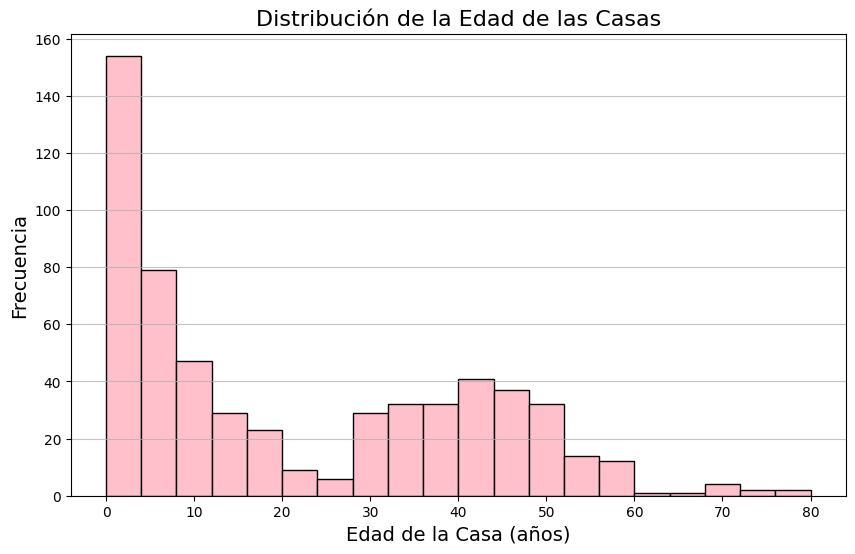

In [ ]:
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
plt.figure(figsize=(10, 6))
plt.hist(df["HouseAge"], bins=20, edgecolor='black', color='pink')
plt.title('Distribución de la Edad de las Casas', fontsize=16)
plt.xlabel('Edad de la Casa (años)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

La distribución de las antigüedad de las casas tiene alta variablidad, el pico más alto se encuentra en las casas que tienen entre 0 y 5 años (casi 160 casas). Luego hay pequeños grupos de casas que se ubican entre los 5 y 28 años aproximadamente. Seguido existe un grupo más homogéneo que está entre los 28 y 60 años y finalmente, las más viejas, un segmento pequeño con más de 60 hasta los 80 años.

**¿Cómo se relaciona el precio con la edad de la casa?**

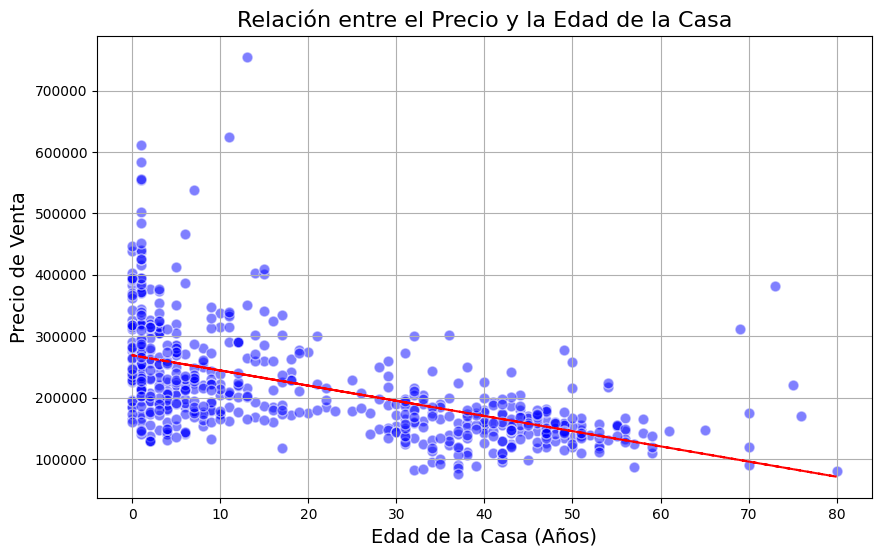

In [ ]:
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
plt.figure(figsize=(10, 6))
plt.scatter(df['HouseAge'], df['SalePrice'], alpha=0.5, c='blue', edgecolors='w', s=60)
z = np.polyfit(df['HouseAge'], df['SalePrice'], 1)
p = np.poly1d(z)
plt.plot(df['HouseAge'], p(df['HouseAge']), "r--")
plt.xlabel('Edad de la Casa (Años)', fontsize=14)
plt.ylabel('Precio de Venta', fontsize=14)
plt.title('Relación entre el Precio y la Edad de la Casa', fontsize=16)
plt.grid(True)
plt.show()

Basado en los resultados del gráfico, parece sugerirse una relación inversa entre el precio de las casas y la edad en años (Entre más años tiene la casa, su valor es menor)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X = df[["HouseAge"]]  # Variable independiente (antigüedad)
y = df["SalePrice"]  # Variable dependiente (precio de venta)

#Datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Creación de modelo lineal y de entrenamiento
model = LinearRegression()
model.fit(X_train, y_train)

#prediciones
y_pred = model.predict(X_test)

#Rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 8445932302.890264
R-squared: 0.25079912809872973


El modelo tiene un MSE relativamente alto y un R-cuadrado bajo. Esto sugiere que la antigüedad sola no es un predictor muy fuerte para los precios de venta. Puede ser necesario incluir más variables o explorar otros modelos para mejorar la predicción del valor a pagar por cada casa.

**¿Cuál es el barrio más pobre?**

In [ ]:
# 1. Promedio/barrio
precio_barrio = df.groupby('Neighborhood')['SalePrice'].mean()
# 2. Barrio más pobre
barrio_mas_pobre = precio_barrio.idxmin()
print(f'El barrio más pobre es: {barrio_mas_pobre}')

El barrio más pobre es: Meadow Village


En la comparación de precios a la venta, las viviendas ubicadas en el barrio: Meadow Village tiene el promedio más bajo respecto al resto de vecindarios, lo cual sugiere que podria ser el barrio más pobre

**¿Cuál es el barrio más cercano a vías férreas?**

In [ ]:
# Filtrar propiedades cercanas a vías férreas
rail_conditions = ['RRNn', 'RRAn', 'RRNe', 'RRAe']
near_railroads = df[df['Condition1'].isin(rail_conditions) | df['Condition2'].isin(rail_conditions)]
# Contar la cantidad de propiedades cercanas a vías férreas por barrio
vias_ferreas_barrio = near_railroads.groupby('Neighborhood').size()
barrio_cercano_vias = vias_ferreas_barrio.idxmax()
print(f'El barrio con más propiedades cercanas a vías férreas es: {barrio_cercano_vias}')

El barrio con más propiedades cercanas a vías férreas es: Somerset


In [ ]:
print(vias_ferreas_barrio)

Neighborhood
Brookside         1
Gilbert           2
Northwest Ames    4
Sawyer            2
Sawyer West       1
Somerset          5
dtype: int64


**¿Cuál es la cobertura más común en las casas que se encuentran el el top 10% en precio?**

In [ ]:
# Top 10% de casas por precio de venta
top_10 = df[df['SalePrice'] >= df['SalePrice'].quantile(0.9)]

# Cobertura más común
cobertura_comun = top_10['RoofStyle'].mode().iloc[0]
print(f'La cobertura más común en las casas del top 10% en precio es: {cobertura_comun}')

La cobertura más común en las casas del top 10% en precio es: Hip


In [ ]:
# Exterior más común
exterior_comun = top_10['Exterior1st'].mode().iloc[0]
print(f'El exterior más común en las casas del top 10% en precio es: {exterior_comun}')

El exterior más común en las casas del top 10% en precio es: VinylSd


In [ ]:
# Exterior más común2
exterior_comun2 = top_10['Exterior2nd'].mode().iloc[0]
print(f'El exterior2 más común en las casas del top 10% en precio es: {exterior_comun2}')

El exterior2 más común en las casas del top 10% en precio es: VinylSd


**¿En qué barrio hay mayor desigualdad?**

In [ ]:
# DE Precio de venta
DE_PV = df.groupby('Neighborhood')['SalePrice'].std()

# Barrio con mayor desigualdad
barrio_mayor_desigualdad = DE_PV.idxmax()
print(f'El barrio con mayor desigualdad es: {barrio_mayor_desigualdad}')

El barrio con mayor desigualdad es: Northridge


**¿En qué año hubo más movimiento del mercado inmobiliario?**

In [ ]:
# Número de ventas por año
ventas_año = df['YrSold'].value_counts()
# Año con mayor número de ventas
ventas_año = ventas_año.idxmax()
print(f'El año con más movimiento en el mercado inmobiliario fue: {ventas_año}')

El año con más movimiento en el mercado inmobiliario fue: 2007


**¿Cuáles son los 2 barrios con mayor industria cerca?** - Por proximidad

In [ ]:
IND_c = ['Artery', 'Feedr']
industria_barrio = df[(df['Condition1'].isin(IND_c)) | (df['Condition2'].isin(IND_c))].groupby('Neighborhood').size()
barrios_mayor_industria = industria_barrio.nlargest(2)
print(f'Los 2 barrios con más propiedades cercanas a zonas industriales son: {barrios_mayor_industria.index.tolist()}')

Los 2 barrios con más propiedades cercanas a zonas industriales son: ['Northwest Ames', 'Sawyer West']


Por proximidad se asume que los barrios con propiedades cercanas a zonas industriales son los que en en condición 1 y condición 2 cumplen con: Vía arterial - vía urbana de alta capacidad, y camino/vía de acceso de acceso

**¿Cuáles son los 2 barrios con mayor comercio cerca?** - Por proximidad

In [ ]:
COM_c = ['Norm', 'Feedr', 'PosN', 'PosA']
comercio_barrio = df[(df['Condition1'].isin(COM_c)) | (df['Condition2'].isin(COM_c))].groupby('Neighborhood').size()
barrios_mayor_comercio = comercio_barrio.nlargest(2)
print(f'Los 2 barrios con más propiedades cercanas a zonas comerciales son: {barrios_mayor_comercio.index.tolist()}')

Los 2 barrios con más propiedades cercanas a zonas comerciales son: ['College Creek', 'Northridge Heights']


Por proximidad se asume que los barrios con propiedades cercanas a zonas comerciales son los que en en condición 1 y condición 2 cumplen con: camino/vía de acceso de acceso, normal, cercanía o junto a externalidades positivas (Parque, zonas verdes)

In [ ]:
Zona = pd.crosstab(df['Neighborhood'], df['MSZoning'])
Zona

MSZoning,FV,RH,RL,RM
Neighborhood,,,,
Bloomington Heights,0,0,15,1
Briardale,0,0,0,15
Brookside,0,0,3,0
Clear Creek,0,0,8,0
College Creek,0,0,64,10
Crawford,0,1,10,3
Edwards,0,0,18,7
Gilbert,0,0,20,0
Iowa DOT and Rail Road,0,0,0,1


De acuerdo a la tabla "Zonas" que relaciona las distintas categorias para la clasificación de la zona, en la categoria Industrial no se reporta ningun Barrio